# Run and find start ares
Set up an OGGM/VAS run from scratch and test the start area seeking tasks. The only thing to specify ist the **RGI ID** and the glacier's name, the rest should run without any adjustments...

In [1]:
# import externals libs
import os
import shutil
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, minimize_scalar

# import the needed OGGM modules
import oggm
from oggm import cfg, utils
from oggm.utils import get_rgi_glacier_entities
from oggm.tests.funcs import get_test_dir
from oggm.core import gis, climate, centerlines
from oggm.core import vascaling

%matplotlib inline

**Initialization**

In [2]:
# load parametere file
cfg.initialize()

2019-03-27 13:05:46: oggm.cfg: Using configuration file: /Users/oberrauch/oggm-fork/oggm/params.cfg


**RGI entity**

In [36]:
# get list of demo glaciers and select those in the Alps/HistAlp domain
demo_glaciers = pd.read_csv('/Users/oberrauch/oggm-fork/oggm/data/demo_glaciers.csv', index_col=1)
demo_glaciers = demo_glaciers[demo_glaciers.RGIId.str.contains('11.')]
# add historic area from RGI/GLIMS
demo_glaciers['area_1850_km2'] = [15.4, 5.11, 105.61, np.NaN, np.NaN, 10.12, 33.41]
demo_glaciers

,RGIId,Name
Key,,
hef,RGI60-11.00897,Hintereisferner
kwf,RGI60-11.00787,Kesselwandferner
aletsch,RGI60-11.01450,Großer Aletschgletscher
mdg,RGI60-11.03643,Mer de Glace
argentiere,RGI60-11.03638,Argentière
ogg,RGI60-11.01270,Oberer Grindelwald Glacier
uaar,RGI60-11.01328,Unteraargletscher


In [104]:
demo_glaciers['area_1850_km2'] = [15.4, 5.11, 105.61, np.NaN, np.NaN, 10.12, 33.41]
demo_glaciers

,RGIId,Name,area_km2_1850
Key,,,
hef,RGI60-11.00897,Hintereisferner,15.40
kwf,RGI60-11.00787,Kesselwandferner,5.11
aletsch,RGI60-11.01450,Großer Aletschgletscher,105.61
mdg,RGI60-11.03643,Mer de Glace,NaN
argentiere,RGI60-11.03638,Argentière,NaN
ogg,RGI60-11.01270,Oberer Grindelwald Glacier,10.12
uaar,RGI60-11.01328,Unteraargletscher,33.41


In [94]:
demo_glaciers[demo_glaciers['RGIId'] == rgi_df.loc[ind].RGIId]

,RGIId,Name
Key,,
mdg,RGI60-11.03643,Mer de Glace


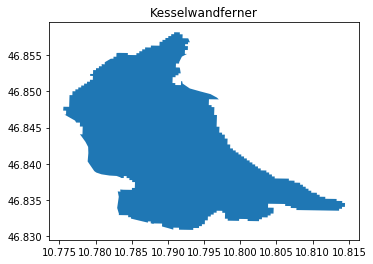

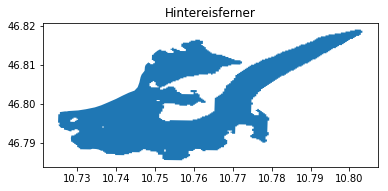

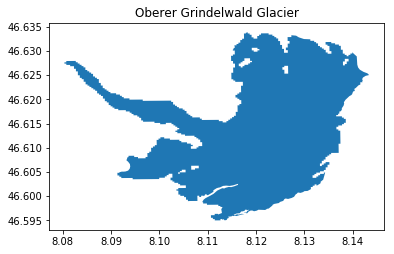

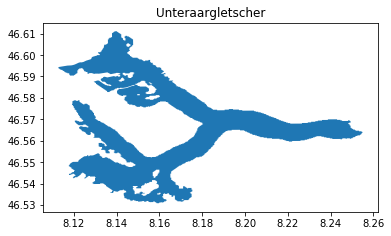

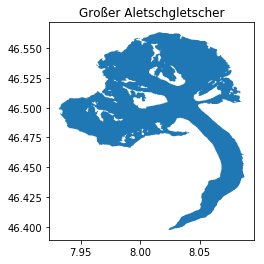

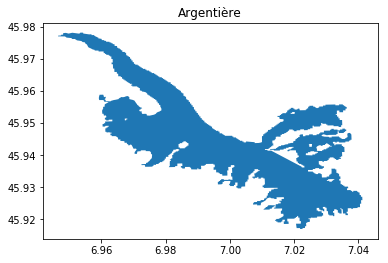

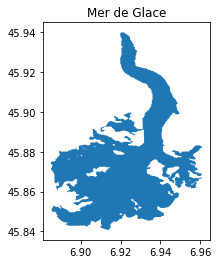

In [101]:
rgi_df = get_rgi_glacier_entities(demo_glaciers.RGIId)
for i, ind in enumerate(rgi_df.index):
    rgi_entity = rgi_df.loc[[ind]]
    rgi_entity.plot()
    rgi_entity = rgi_entity.iloc[-1]
    glacier = demo_glaciers.loc[demo_glaciers['RGIId'] == rgi_entity.RGIId]
    plt.title(glacier.Name[-1])

In [38]:
# choose glacier
glacier = demo_glaciers.loc['kwf']
name = glacier.Name
rgi_id = glacier.RGIId

In [5]:
# get/downlaod the rgi entity including the outline shapefile
rgi_df = get_rgi_glacier_entities([rgi_id])
# set name, since not delivered with RGI
if rgi_df.loc[int(rgi_id[-5:])-1, 'Name'] == None:
    rgi_df.loc[int(rgi_id[-5:])-1, 'Name'] = name
    
rgi_df

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Aspect,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry
786,RGI60-11.00787,G010791E46842N,20030799,20030999,10.7907,46.8424,11,1,3.965,2773,...,123,4202,0,0,0,0,9,1,Kesselwandferner,"POLYGON ((10.79280974900007 46.85732807100004,..."


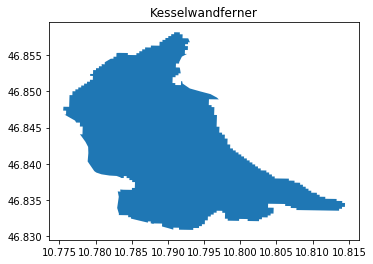

In [6]:
# select single entry
rgi_entity = rgi_df.iloc[0]
# visualize
rgi_df.plot()
plt.title(rgi_entity.Name);

**Glacier Directory**

In [7]:
# specify the working directory and define the glacier directory
cfg.PATHS['working_dir'] = './'
gdir = oggm.GlacierDirectory(rgi_entity, reset=True)

**DEM and GIS tasks**

In [8]:
# get the path to the DEM file (will download if necessary)
dem = utils.get_topo_file(gdir.cenlon, gdir.cenlat)
print('DEM source: {}, path to DEM file: {}'.format(dem[1], dem[0][0]))
# set path in config file
cfg.PATHS['dem_file'] = dem[0][0]
cfg.PARAMS['border'] = 10
cfg.PARAMS['use_intersects'] = False

DEM source: SRTM, path to DEM file: /Users/oberrauch/OGGM/tmp/srtm_39_03.tif


In [9]:
gis.define_glacier_region(gdir, entity=rgi_entity)
gis.glacier_masks(gdir)

2019-03-27 13:05:51: oggm.core.gis: (RGI60-11.00787) define_glacier_region
2019-03-27 13:05:51: oggm.core.gis: (RGI60-11.00787) glacier_masks


**Climate data**

In [10]:
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
climate.process_histalp_data(gdir)

2019-03-27 13:05:51: oggm.core.climate: (RGI60-11.00787) process_histalp_data


**Centerlines**

**Mass balance model**

In [11]:
# compute local t* and the corresponding mu*
vascaling.local_t_star(gdir)
# see calibration results
gdir.read_json('vascaling_mustar')

{'rgi_id': 'RGI60-11.00787',
 't_star': 1942,
 'bias': 0.6079730870067408,
 'mu_star': 57.915393792720835}

In [12]:
# create mass balance model
mb_mod = vascaling.VAScalingMassBalance(gdir)

Text(0,0.5,'Mass balance [mm w.e. yr$^{-1}$]')

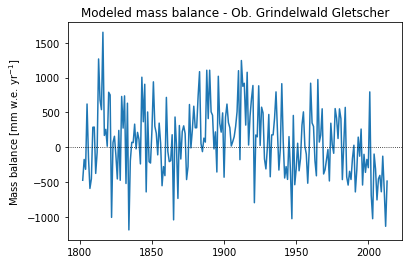

In [13]:
min_hgt, max_hgt = vascaling.get_min_max_elevation(gdir)
y0 = 1802
y1 = 2014
years = np.arange(y0, y1)
mb = list()
for y in years:
    mb.append(mb_mod.get_specific_mb(min_hgt, max_hgt, y))
    
plt.plot(years, mb)
plt.axhline(0, c='k', ls=':', lw=0.8)
plt.title('Modeled mass balance - {}'.format('Ob. Grindelwald Gletscher'))
plt.ylabel('Mass balance [mm w.e. yr$^{-1}$]')

**Find start area**

In [14]:
# run scalar minimization
minimize_res = vascaling.find_start_area(gdir)
minimize_res

     fun: 4.672303433039815e-09
 message: 'Solution found.'
    nfev: 23
  status: 0
 success: True
       x: 6654917.326469763

In [15]:
# instance glacier with todays values
model_ref = vascaling.VAScalingModel(year_0=gdir.rgi_date,
                                     area_m2_0=gdir.rgi_area_m2,
                                     min_hgt=min_hgt, max_hgt=max_hgt,
                                     mb_model=mb_mod)

In [16]:
# instance guessed starting areas
num = 15
area_guess = np.linspace(100, gdir.rgi_area_m2*2,  num, endpoint=True)
# create empty containers
iteration_list = list()
spec_mb_list = list()

# iterate over all starting areas
for area_ in area_guess:
    # instance iteration model
    model_guess = vascaling.VAScalingModel(year_0=gdir.rgi_date,
                                           area_m2_0=gdir.rgi_area_m2,
                                           min_hgt=min_hgt, max_hgt=max_hgt,
                                           mb_model=mb_mod)
    # set new starting values
    model_guess.create_start_glacier(area_)
    # run model and save years and area
    diag_ds = model_guess.run_until_and_store(year_end=model_ref.year)
    # create series and store in container
    iteration_list.append(diag_ds.area_m2.to_dataframe()['area_m2'])
    spec_mb_list.append(diag_ds.spec_mb.to_dataframe()['spec_mb'])
    
# create DataFrame
iteration_df = pd.DataFrame(iteration_list, index=['{:.2f}'.format(a/1e6) for a in area_guess])
iteration_df.index.name = 'Start Area [km$^2$]'

In [17]:
# set up model with resulted starting area
model = vascaling.VAScalingModel(year_0=model_ref.year_0,
                                 area_m2_0=model_ref.area_m2_0,
                                 min_hgt=model_ref.min_hgt_0,
                                 max_hgt=model_ref.max_hgt,
                                 mb_model=model_ref.mb_model)
model.create_start_glacier(minimize_res.x)

# run
diag_ds = model.run_until_and_store(year_end=model_ref.year)

Text(0.5,0.98,'Modelled glacier area - Kesselwandferner')

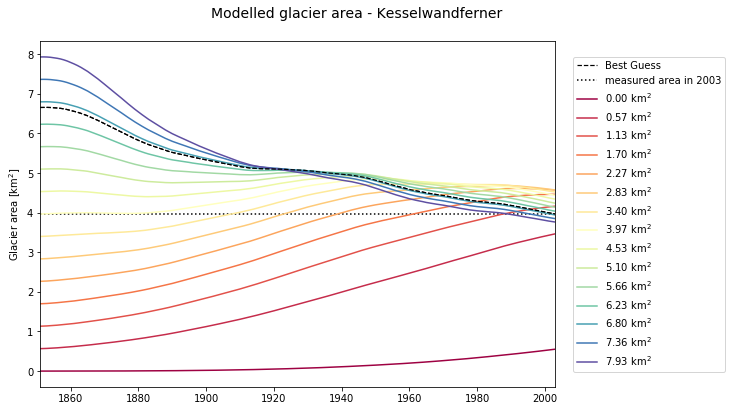

In [21]:
# create figure and add axes
fig = plt.figure(figsize=[11, 6])
ax = fig.add_axes([0.1, 0.1, 0.65, 0.8])
# plot
ax.plot(diag_ds.time, diag_ds.area_m2/1e6, color='k', ls='--', lw=1.2, label='Best Guess')
ax.axhline(model_ref.area_m2_0/1e6, c='k', ls=':', label='measured area in {}'.format(gdir.rgi_date))
ax = (iteration_df/1e6).T.plot(legend=False, colormap='Spectral', ax=ax)
# add legend
handels, labels = ax.get_legend_handles_labels()
labels[2:] = [r'{} km$^2$'.format(l) for l in labels[2:]]
ax.legend(handels, labels, bbox_to_anchor=(1.025, 0.5), loc='center left')

# replot best guess estimate (in case it lies below another guess)
ax.plot(diag_ds.time, diag_ds.area_m2/1e6, color='k', ls='--', lw=1.2, label='Best Guess')

# labels, title
ax.set_xlim([diag_ds.time.values[0], diag_ds.time.values[-1]])
ax.set_xlabel('')
ax.set_ylabel('Glacier area [km$^2$]')
fig.suptitle('Modelled glacier area - {}'.format(rgi_entity.Name), fontsize='14')